*******
<div style="padding:20px;color:black;margin:0;font-size:200%;text-align:center;display:fill;border-radius:5px;background-color:#bdd6f5;overflow:hidden;font-weight:500">Prédiction de la consommation d'énergie des bâtiments publiques à Seattle</div>

*******

### Tables des matières<a class="anchor" id="retour"></a>

[Présentation de la partie 2](#Présentation)


* [Partie 3 🛠 Machine Learning (Régression) ](#Partie_2)

    * [3.1 Régression lineaire comme baseline](#Section_2.1)
    * [3.2 Régression linéaire sur données centrées réduite](#Section_2.2)
    * [3.3 Régression Ridge ](#Section_2.3)
    * [3.4 Régression LASSO ](#Section_2.4)
    * [3.5 Régression sur les 3 premières composantes principales ](#Section_2.5)
    * [3.6 Régression linéaire sur données en log ](#Section_2.6)
    * [3.7 Gradient Boosting regressor sur données en log (Scikit Learn) ](#Section_2.7)
    * [3.8 XGBoost](#Section_2.8)
    * [3.9 XGBoost (avec ENERGYSTARScore)](#Section_2.9)


[Conclusion partie 2](#Conclusion)

[Références](#Références)

****
<div style="padding:20px;color:black;margin:0;font-size:200%;display:fill;border-radius:5px;background-color:#e9f1fc;overflow:hidden;font-weight:500">Partie 2 🛠 Machine Learning (Régression)</div>
<a class="anchor" id="Partie_2"></a>

****

In [303]:
# Importation des librairies

import pandas as pd
import numpy as np

# Lib pour réaliser des graphiques
import matplotlib.pyplot as plt
import seaborn as sns

# Lib pour mesurer le temps execution
import time


# Lib pour regression linéaire
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
import xgboost
from xgboost import XGBRegressor

# Lib pour séparer les données en 2 sets
from sklearn.model_selection import train_test_split

# Lib pour travailler sur les données CR
from sklearn import preprocessing
from sklearn.decomposition import PCA
import sklearn.decomposition

# Lib pour remplacer les données manquantes
from sklearn.impute import KNNImputer

# Lib pour réccupérer le RMSE
from sklearn.metrics import mean_squared_error

# Lib pour le passage en log
import math

# Lib pour le gridsearch et les métriques
from sklearn.model_selection import GridSearchCV
from sklearn import  metrics

## Présentation partie 3
<a class="anchor" id="Partie_2"></a>

Cette étude a pour objectif de présenter les différentes méthodes de régression linéaire des librairies
Scikit learn et la très populaire XGBoost.
Il s'agit d'expliquer la variable "TotalGHGEmissions"


In [304]:
# Importation des données
df = pd.read_csv("df.csv",sep=";")
df_float = pd.read_csv("df_float.csv",sep=";")
df_objet = pd.read_csv("df_objet.csv",sep=";")

In [305]:
# Suppression des colonnes inutiles
df_float = df_float.drop(columns=["Unnamed: 0"])
df_objet = df_objet.drop(columns=["Unnamed: 0"])
df = df.drop(columns=["Unnamed: 0"])

In [306]:
target = df[["TotalGHGEmissions"]]

### Création de fonctions

In [307]:
# Création d'une fonction qui renvoit le RMSE

def rmse(X_test,pred):
    MSE = mean_squared_error(y_test, pred.prediction)
    RMSE = math.sqrt(MSE)
    return print(RMSE)

In [308]:
# Création d'une fonction qui passe un df au log

def df_au_log(data_1):
    val = np.log(data_1.values)
    data_2 = pd.DataFrame(data=val,columns=data_1.columns,index=data_1.index)
    return data_2

In [309]:
# Création d'une fonction composé des coeff de la regression triés par ordre en valeur absolue

def coef_sort(model):
    coef = pd.DataFrame(data=model.coef_,columns=df_float.columns)
    coef = pd.DataFrame(data=coef.transpose().values,columns=["coeff"],
                        index=coef.transpose().index)
    coef["coeff_sort"] = coef["coeff"].abs()
    coef = coef.sort_values(by="coeff_sort",ascending=False)
    return coef

## 2.1) Régression linéaire comme baseline
<a class="anchor" id="Section_2.1"></a>

In [310]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float, target, test_size=0.3, random_state=0)

# Régression linéaire
tps1 = time.time()
model = LinearRegression().fit(X_train, y_train)
tps2 = time.time()
temps = tps2 - tps1
print("Temps de calcul : ",temps,"ms")

Temps de calcul :  0.015622377395629883 ms


### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [311]:
print("R2 sur le set d'apprentissage: ",model.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.370675397994099 
 R2 sur le set de test:  0.07287515753838025


In [312]:
# Création d'un DF des valeurs prédites de X_test
pred = model.predict(X_test)
pred = pd.DataFrame(pred,columns=["prediction"])
pred

# Affichage du RMSE
rmse(X_test,pred)

729.2730217527325


In [313]:
# Création d'un DF composée de la target la prédiction et les résidus

y_model = y_test.merge(df_float["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_model = pd.DataFrame(y_model).reset_index()
y_model = y_model.drop(columns=["index"])
pred = pd.concat([y_model[["TotalGHGEmissions","PropertyGFATotal"]],pred],axis=1)
pred["residus"] = pred["TotalGHGEmissions"]-pred["prediction"]
pred

,TotalGHGEmissions,PropertyGFATotal,prediction,residus
0,7.34,56340,39.109735,-31.769735
1,4.67,30796,-46.987894,51.657894
2,3.41,23177,-56.543961,59.953961
3,8.61,25000,45.903942,-37.293942
4,37.31,20539,9.586448,27.723552
...,...,...,...,...
1000,9.68,55842,50.585312,-40.905312
1001,163.19,526423,940.660426,-777.470426
1002,138.03,40329,37.965739,100.064261
1003,136.07,220018,137.433047,-1.363047


Text(0.5, 1.0, 'Prédiction de 97% des points')

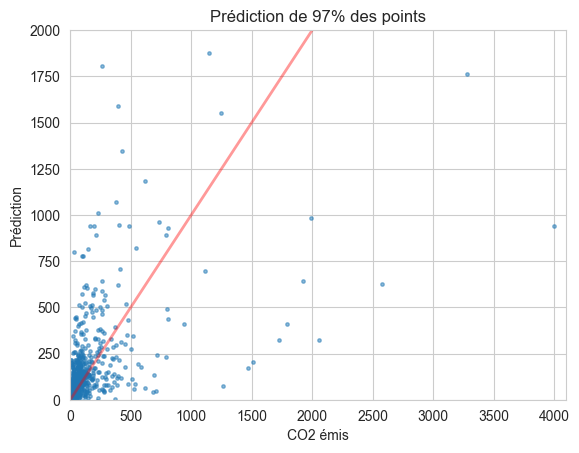

In [314]:
# Représentation graphique de la prédiction
axes = plt.gca()
plt.scatter(data=pred, x="TotalGHGEmissions", y="prediction", alpha=0.5, s=6)
plt.plot([0.0,2_000 ], [0.0,2_000 ], 'r-', lw=2, alpha=0.4)

plt.xlim(0, 4_100)
plt.ylim(0, 2_000)

axes.set_xlabel('CO2 émis')
axes.set_ylabel('Prédiction')

plt.title('Prédiction de 97% des points')

In [315]:
# Création d'un DF composé des coeff de la regression
coef = coef_sort(model)
coef

,coeff,coeff_sort
tx_gaz,159.180985,159.180985
NumberofBuildings,72.423517,72.423517
NumberofFloors,-11.588756,11.588756
BulType,5.077309,5.077309
Council,-3.378538,3.378538
PPT,-3.202020,3.202020
Zip,-0.946664,0.946664
Voisin,-0.511408,0.511408
years,0.377853,0.377853
ThirdLargestPropertyUseTypeGFA,-0.006672,0.006672


Text(0.5, 1.0, 'Coefficients de regression')

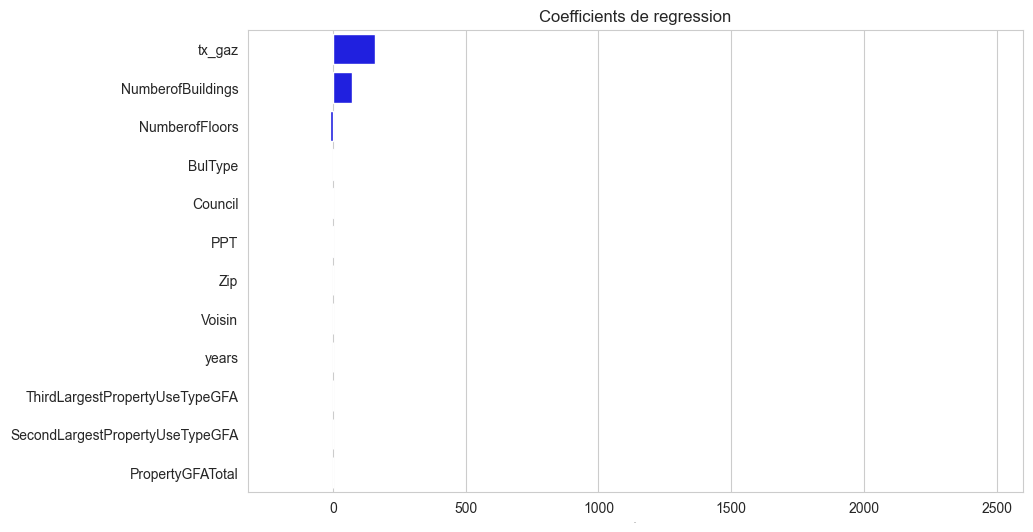

In [316]:
# Bar Plot des coeff

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlim(-320, 2_600)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

## 2.2) Régression linéaire sur données centrées réduites
<a class="anchor" id="Section_2.2"></a>

Le modèle n'a pas l'air capable de prédire les 10 plus grandes valeur de la target.
Nous ne les conservons pas pour vérifier si le modèle est plus performant.
De plus nous travaillons dans cette partie sur les données centrées réduites

In [317]:
# Données centrées réduite sur toute la table entière

std_scale = preprocessing.StandardScaler().fit(df_float)
df_float_cr = std_scale.transform(df_float)

std_scale = preprocessing.StandardScaler().fit(target)
target_cr =  std_scale.transform(target)

# Permet d'avoir en output du modèle un DF
target_cr = pd.DataFrame(data=target_cr,columns=["TotalGHGEmissions"],index=target.index)
df_float_cr = pd.DataFrame(data=df_float_cr,columns=df_float.columns,index=df_float.index)

# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_cr, target_cr,
                                                    test_size=0.3, random_state=0)

# Régression linéaire
tps1 = time.time()
model_cr = LinearRegression().fit(X_train, y_train)
tps2 = time.time()
temps_cr = tps2 - tps1
print("Temps de calcul : ",temps_cr,"ms")

Temps de calcul :  0.0 ms


### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [318]:
print("R2 sur le set d'apprentissage: ",model_cr.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_cr.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.3706753979940991 
 R2 sur le set de test:  0.0728751575379667


In [319]:
# Création d'un DF des valeurs prédites de X_test
pred = model_cr.predict(X_test)
pred=pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

1.350164747521045


In [320]:
# Création d'un DF composée de la target la prédiction et les résidus

y_cr = y_test.merge(df_float_cr["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_cr = pd.DataFrame(y_cr).reset_index()
y_cr = y_cr.drop(columns=["index"])
pred = pd.concat([y_cr[["TotalGHGEmissions","PropertyGFATotal"]],pred],axis=1)
pred["residus"] = pred["TotalGHGEmissions"]-pred["prediction"]
pred


,TotalGHGEmissions,PropertyGFATotal,prediction,residus
0,-0.208817,-0.175740,-0.149999,-0.058818
1,-0.213760,-0.292659,-0.309399,0.095639
2,-0.216093,-0.327532,-0.327091,0.110998
3,-0.206466,-0.319188,-0.137420,-0.069045
4,-0.153331,-0.339606,-0.204658,0.051327
...,...,...,...,...
1000,-0.204485,-0.178019,-0.128753,-0.075731
1001,0.079721,1.975903,1.519118,-1.439397
1002,0.033141,-0.249025,-0.152117,0.185257
1003,0.029512,0.573440,0.032035,-0.002524


Text(0.5, 1.0, 'Prédiction de 92% des points')

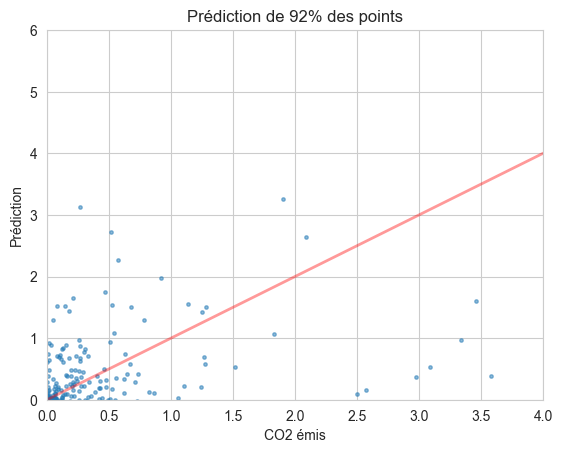

In [321]:
# Représentation graphique de la prédiction
axes = plt.gca()
plt.scatter(data=pred, x="TotalGHGEmissions", y="prediction", alpha=0.5, s=6)
plt.plot([0.0, 10], [0.0, 10], 'r-', lw=2, alpha=0.4)

plt.xlim(0, 4)
plt.ylim(0, 6)

axes.set_xlabel('CO2 émis')
axes.set_ylabel('Prédiction')

plt.title('Prédiction de 92% des points')

In [322]:
# Création d'un DF composé des coeff de la regression
coef = coef_sort(model_cr)
coef

,coeff,coeff_sort
PropertyGFATotal,0.543968,0.543968
NumberofBuildings,0.283459,0.283459
SecondLargestPropertyUseTypeGFA,0.170794,0.170794
ThirdLargestPropertyUseTypeGFA,-0.162465,0.162465
NumberofFloors,-0.118249,0.118249
tx_gaz,0.079597,0.079597
PPT,-0.034561,0.034561
years,0.023182,0.023182
Zip,-0.017629,0.017629
Council,-0.013266,0.013266


Text(0.5, 1.0, 'Coefficients de regression')

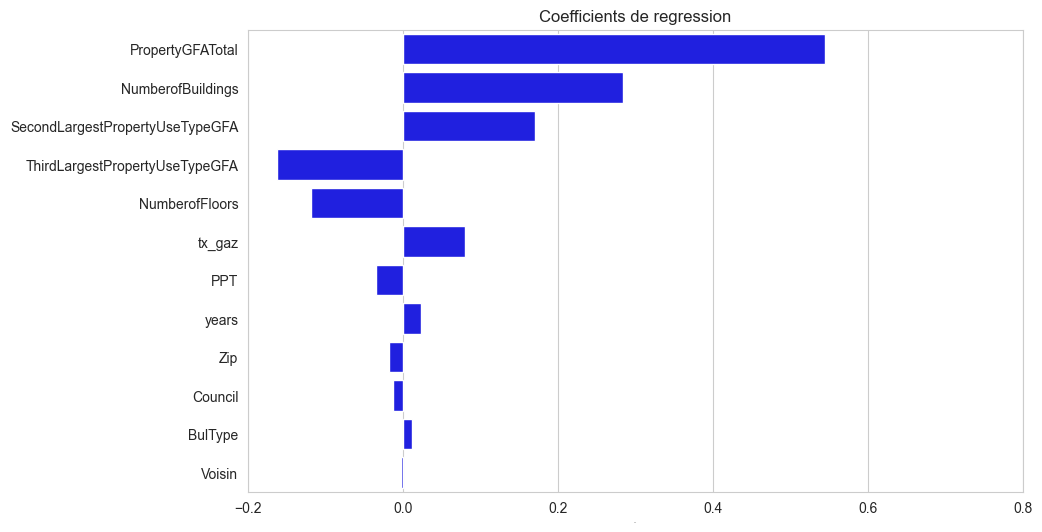

In [323]:
# Graphique des coeff
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlim(-0.2, 0.8)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

## 2.3) Régression Ridge
<a class="anchor" id="Section_2.3"></a>

Regression Ridge sur les données centrées réduites.
Utilisation d'un gridsearch afin de tester plusieurs hyperparamètre

In [324]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_cr, target_cr, test_size=0.3, random_state=0)

In [325]:
# Modèle RIDGE

tps1 = time.time()

score="r2"
param_grid = { "alpha":[0.2,0.4,0.6,0.8,0.9,2,5,9,10,11,12,50,100]}

model_ridge = GridSearchCV( Ridge(),
                            param_grid,
                            cv=10,
                            scoring=score )

model_ridge.fit(X_train,y_train)

tps2 = time.time()
temps_ridge = tps2 - tps1
print("Temps de calcul : ",temps_ridge,"s")

Temps de calcul :  1.4812660217285156 s


In [326]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model_ridge.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 100}


In [327]:
# Afficher les performances correspondantes

result = "mean_test_score"
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        model_ridge.cv_results_['mean_test_score'], # score moyen
        model_ridge.cv_results_['std_test_score'],  # écart-type du score
        model_ridge.cv_results_['params'] ):          # valeur de l'hyperparamètre

    print("{} = {:.3f} (+/-{:.03f}) for {}".format( result,
                                                    mean,
                                                    std*2,
                                                    params ) )

Résultats de la validation croisée :
mean_test_score = -0.257 (+/-1.283) for {'alpha': 0.2}
mean_test_score = -0.257 (+/-1.283) for {'alpha': 0.4}
mean_test_score = -0.257 (+/-1.282) for {'alpha': 0.6}
mean_test_score = -0.256 (+/-1.281) for {'alpha': 0.8}
mean_test_score = -0.256 (+/-1.280) for {'alpha': 0.9}
mean_test_score = -0.254 (+/-1.275) for {'alpha': 2}
mean_test_score = -0.247 (+/-1.261) for {'alpha': 5}
mean_test_score = -0.239 (+/-1.243) for {'alpha': 9}
mean_test_score = -0.237 (+/-1.239) for {'alpha': 10}
mean_test_score = -0.235 (+/-1.235) for {'alpha': 11}
mean_test_score = -0.233 (+/-1.230) for {'alpha': 12}
mean_test_score = -0.167 (+/-1.083) for {'alpha': 50}
mean_test_score = -0.101 (+/-0.932) for {'alpha': 100}


In [328]:
model_ridge.best_estimator_

Ridge(alpha=100)

In [329]:
reg_ridge= Ridge(alpha=0.2)
reg_ridge.fit(X_train,y_train)

Ridge(alpha=0.2)

In [330]:
# Création d'un DF composé des coeff de la regression
coef = coef_sort(reg_ridge)
coef

,coeff,coeff_sort
PropertyGFATotal,0.543702,0.543702
NumberofBuildings,0.283412,0.283412
SecondLargestPropertyUseTypeGFA,0.170868,0.170868
ThirdLargestPropertyUseTypeGFA,-0.162400,0.162400
NumberofFloors,-0.118176,0.118176
tx_gaz,0.079595,0.079595
PPT,-0.034555,0.034555
years,0.023173,0.023173
Zip,-0.017625,0.017625
Council,-0.013266,0.013266


Text(0.5, 1.0, 'Coefficients de regression')

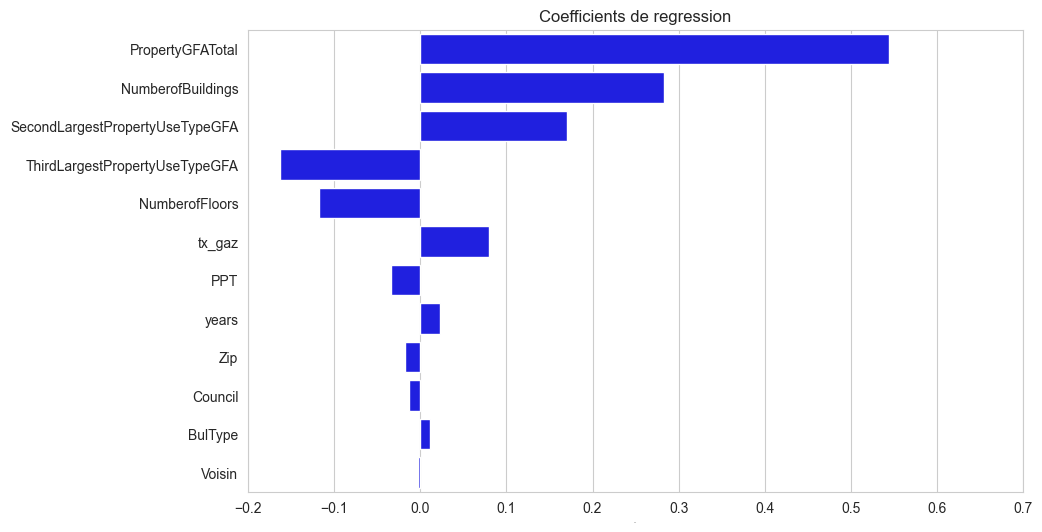

In [331]:
# Représentation graphique des coefficients

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-0.2,0.7)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [332]:
print("R2 sur le set d'apprentissage: ",model_ridge.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_ridge.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.3667947271786136 
 R2 sur le set de test:  0.18801985296459667


In [333]:
# Création d'un DF des valeurs prédites de X_test
pred = model_ridge.predict(X_test)
pred = pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

1.2635439737124872


In [334]:
# Création d'un DF composée de la target la prédiction et les résidus

y_ridge = y_test.merge(df_float_cr["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_ridge = pd.DataFrame(y_ridge).reset_index()
y_ridge=y_ridge.drop(columns=["index"])
pred = pd.concat([y_ridge[["TotalGHGEmissions","PropertyGFATotal"]],pred],axis=1)
pred["residus"]=pred["TotalGHGEmissions"]-pred["prediction"]
pred

,TotalGHGEmissions,PropertyGFATotal,prediction,residus
0,-0.208817,-0.175740,-0.161728,-0.047089
1,-0.213760,-0.292659,-0.288209,0.074449
2,-0.216093,-0.327532,-0.312391,0.096298
3,-0.206466,-0.319188,-0.128903,-0.077563
4,-0.153331,-0.339606,-0.175367,0.022036
...,...,...,...,...
1000,-0.204485,-0.178019,-0.130353,-0.074132
1001,0.079721,1.975903,1.469366,-1.389645
1002,0.033141,-0.249025,-0.125231,0.158372
1003,0.029512,0.573440,0.077655,-0.048143


Text(0.5, 1.0, 'Prédiction de 97% des points')

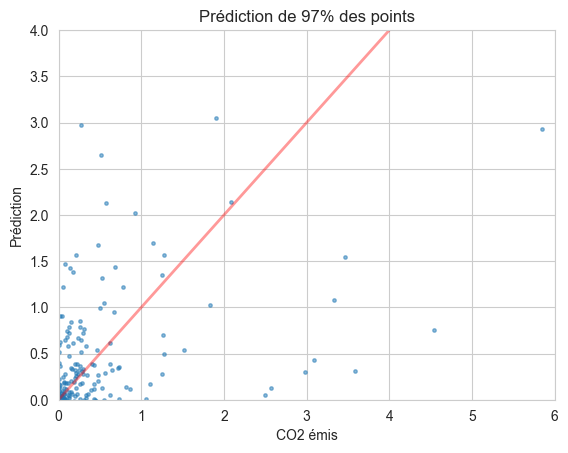

In [335]:
# Représentation graphique de la prédiction
axes = plt.gca()
plt.scatter(data=pred, x="TotalGHGEmissions", y="prediction", alpha=0.5, s=6)
plt.plot([0.0, 10], [0.0, 10], 'r-', lw=2, alpha=0.4)

plt.xlim(0, 6)
plt.ylim(0, 4)

axes.set_xlabel('CO2 émis')
axes.set_ylabel('Prédiction')

plt.title('Prédiction de 97% des points')

La régression Ridge n'a pas amélioré le pouvoir prédictif du modèle

## 2.4) Régression LASSO
<a class="anchor" id="Section_2.4"></a>

In [336]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_cr, target_cr,
                                                    test_size=0.3, random_state=0)

In [337]:
# Modèle LASSO
tps1 = time.time()

score="r2"
param_grid = { "alpha":[0.1,0.2,0.4,0.6,0.8,0.9,2,5,9,10,11,12,50,100]}

model_lasso = GridSearchCV( Lasso(),
                      param_grid,
                      cv=10,
                      scoring=score)

model_lasso.fit(X_train,y_train)

tps2 = time.time()
temps_lasso = tps2 - tps1
print("Temps de calcul : ",temps_lasso,"s")

Temps de calcul :  2.2095754146575928 s


In [338]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model_lasso.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.1}


In [339]:
# Afficher les performances correspondantes

result = 'mean_test_score'
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        model_lasso.cv_results_['mean_test_score'], # score moyen
        model_lasso.cv_results_['std_test_score'],  # écart-type du score
        model_lasso.cv_results_['params'] ):          # valeur de l'hyperparamètre

    print("{} = {:.3f} (+/-{:.03f}) pour {}".format( result,
                                                     mean,
                                                     std*2,
                                                     params) )

Résultats de la validation croisée :
mean_test_score = 0.167 (+/-0.316) pour {'alpha': 0.1}
mean_test_score = 0.085 (+/-0.200) pour {'alpha': 0.2}
mean_test_score = -0.016 (+/-0.050) pour {'alpha': 0.4}
mean_test_score = -0.016 (+/-0.050) pour {'alpha': 0.6}
mean_test_score = -0.016 (+/-0.050) pour {'alpha': 0.8}
mean_test_score = -0.016 (+/-0.050) pour {'alpha': 0.9}
mean_test_score = -0.016 (+/-0.050) pour {'alpha': 2}
mean_test_score = -0.016 (+/-0.050) pour {'alpha': 5}
mean_test_score = -0.016 (+/-0.050) pour {'alpha': 9}
mean_test_score = -0.016 (+/-0.050) pour {'alpha': 10}
mean_test_score = -0.016 (+/-0.050) pour {'alpha': 11}
mean_test_score = -0.016 (+/-0.050) pour {'alpha': 12}
mean_test_score = -0.016 (+/-0.050) pour {'alpha': 50}
mean_test_score = -0.016 (+/-0.050) pour {'alpha': 100}


In [340]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model_lasso.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.1}


### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [341]:
# Création d'un DF des valeurs prédites de X_test
pred = model_lasso.predict(X_test)
pred = pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

1.199084438839361


In [342]:
print("R2 sur le set d'apprentissage: ",model_lasso.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_lasso.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.24652299782042164 
 R2 sur le set de test:  0.2687527881901348


In [343]:
reg_lasso = Lasso(alpha=0.2)
reg_lasso.fit(X_train,y_train)

Lasso(alpha=0.2)

In [344]:
# Création d'un DF composée de la target la prédiction et les résidus

y_lasso = y_test.merge(df_float_cr["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_lasso = pd.DataFrame(y_lasso).reset_index()
y_lasso=y_lasso.drop(columns=["index"])
pred = pd.concat([y_lasso[["TotalGHGEmissions","PropertyGFATotal"]],pred],axis=1)
pred["residus"]=pred["TotalGHGEmissions"]-pred["prediction"]
pred

,TotalGHGEmissions,PropertyGFATotal,prediction,residus
0,-0.208817,-0.175740,-0.101890,-0.106927
1,-0.213760,-0.292659,-0.130344,-0.083416
2,-0.216093,-0.327532,-0.138831,-0.077261
3,-0.206466,-0.319188,-0.133744,-0.072721
4,-0.153331,-0.339606,-0.125681,-0.027650
...,...,...,...,...
1000,-0.204485,-0.178019,-0.062467,-0.142018
1001,0.079721,1.975903,0.979366,-0.899645
1002,0.033141,-0.249025,-0.113209,0.146350
1003,0.029512,0.573440,0.219780,-0.190268


Text(0.5, 1.0, 'Prédiction de 97% des points')

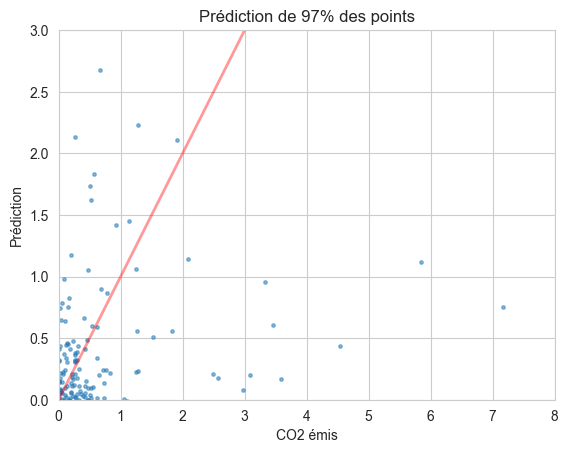

In [345]:
# Représentation graphique de la prédiction
axes = plt.gca()
plt.scatter(data=pred, x="TotalGHGEmissions", y="prediction", alpha=0.5, s=6)
plt.plot([0.0, 10], [0.0, 10], 'r-', lw=2, alpha=0.4)

plt.xlim(0, 8)
plt.ylim(0, 3)

axes.set_xlabel('CO2 émis')
axes.set_ylabel('Prédiction')

plt.title('Prédiction de 97% des points')

In [346]:
# Création d'un DF composé des coefficients

coef = pd.DataFrame(data=reg_lasso.coef_, columns = ["coeff"],index=df_float_cr.columns)
coef["coeff_sort"] = coef["coeff"].abs()
coef = coef.sort_values(by="coeff_sort",ascending=False)
coef

,coeff,coeff_sort
SecondLargestPropertyUseTypeGFA,0.142652,0.142652
PropertyGFATotal,0.007477,0.007477
years,-0.000000,0.000000
NumberofFloors,0.000000,0.000000
NumberofBuildings,0.000000,0.000000
ThirdLargestPropertyUseTypeGFA,0.000000,0.000000
tx_gaz,0.000000,0.000000
BulType,0.000000,0.000000
PPT,-0.000000,0.000000
Zip,-0.000000,0.000000


Text(0.5, 1.0, 'Coefficients de regression')

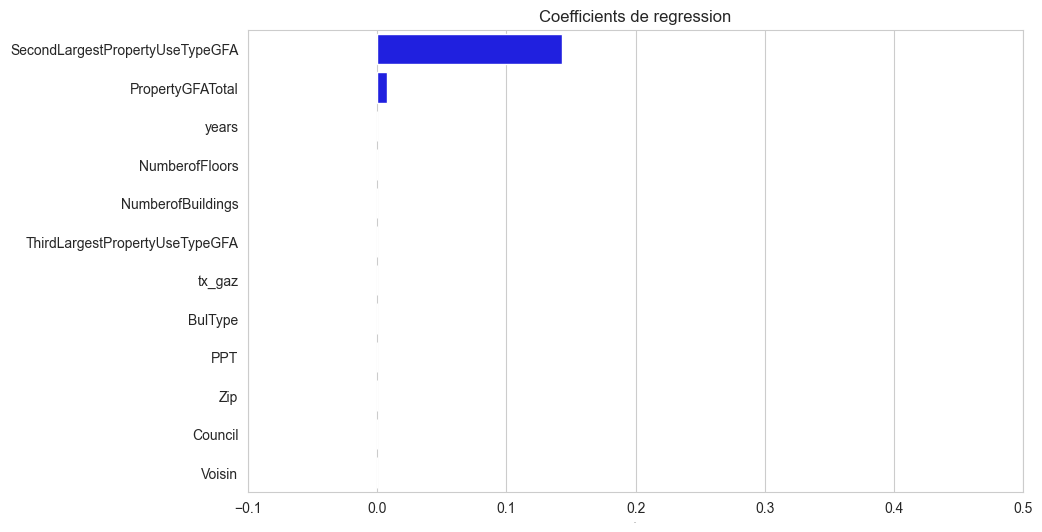

In [347]:
# Représentation graphique des coefficients

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-0.1, 0.5)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

La régression LASSO montre toute son utilité:
- une seule variable permet d'expliquer le modèle
- la pénalité est efficace

## 2.5) Regression sur les 3 premieres composantes principales
<a class="anchor" id="Section_2.5"></a>

In [348]:
liste_r2=[]
liste_var=[]

for i in range(1,12):
    pca = PCA(n_components=i)
    pca.fit(df_float_cr)
    df_pca = pca.fit_transform(df_float_cr)

    X_train, X_test, y_train, y_test = train_test_split(df_pca, target_cr,
                                                    test_size=0.3, random_state=0)

    model_pca = LinearRegression().fit(X_train, y_train)

    liste_r2.append(model_pca.score(X_test, y_test))
    liste_var.append(pca.explained_variance_ratio_.sum())

print(liste_r2,"\n",liste_var)

[0.24797256753169306, 0.37235316526013995, 0.4035762479873931, 0.18601448251585306, 0.2352224452277072, 0.22759402885695978, 0.22841038032694583, 0.16354363868673516, 0.17005737324769676, 0.1528254580988958, 0.12714670866416444] 
 [0.21084113486646935, 0.3408868692249583, 0.4631726858165711, 0.5727674336083725, 0.6552076758927853, 0.7268152664914302, 0.7941615112497836, 0.8591994571774906, 0.9115296291034263, 0.9592194814254725, 0.9903278214059704]


In [349]:
pca = PCA(n_components=3)
pca.fit(df_float_cr)

PCA(n_components=3)

In [350]:
pca.explained_variance_ratio_.sum()

0.4631726858165708

In [351]:
# Création d'un DF ne contenant plus les 5 valeurs les plus grandes
df_pca = pca.fit_transform(df_float_cr)

In [352]:
# Création d'un DF ne contenant plus les 5 valeurs les plus grandes

# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_pca, target_cr,
                                                    test_size=0.3, random_state=0)

# Régression linéaire
tps1 = time.time()
model_pca = LinearRegression().fit(X_train, y_train)
tps2 = time.time()
temps_pca = tps2 - tps1
print("Temps de calcul : ",temps_pca,"ms")

Temps de calcul :  0.0030078887939453125 ms


### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [353]:
print("R2 sur le set d'apprentissage: ",model_pca.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_pca.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.263834347851822 
 R2 sur le set de test:  0.40357624798739256


In [354]:
# Création d'un DF des valeurs prédites de X_test
pred = model_pca.predict(X_test)
pred=pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

1.0829168731806704


In [355]:
# Création d'un DF composée de la target la prédiction et les résidus

y_pca = y_test.merge(df_float_cr["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_pca = pd.DataFrame(y_pca).reset_index()
y_pca = y_pca.drop(columns=["index"])
pred = pd.concat([y_pca[["TotalGHGEmissions","PropertyGFATotal"]],pred],axis=1)
pred["residus"] = pred["TotalGHGEmissions"]-pred["prediction"]
pred

,TotalGHGEmissions,PropertyGFATotal,prediction,residus
0,-0.208817,-0.175740,-0.245992,0.037175
1,-0.213760,-0.292659,-0.130493,-0.083267
2,-0.216093,-0.327532,-0.303275,0.087182
3,-0.206466,-0.319188,0.028839,-0.235304
4,-0.153331,-0.339606,-0.125354,-0.027977
...,...,...,...,...
1000,-0.204485,-0.178019,-0.172451,-0.032033
1001,0.079721,1.975903,1.145021,-1.065299
1002,0.033141,-0.249025,-0.166383,0.199523
1003,0.029512,0.573440,0.106126,-0.076614


Text(0.5, 1.0, 'Prédiction de 97% des points')

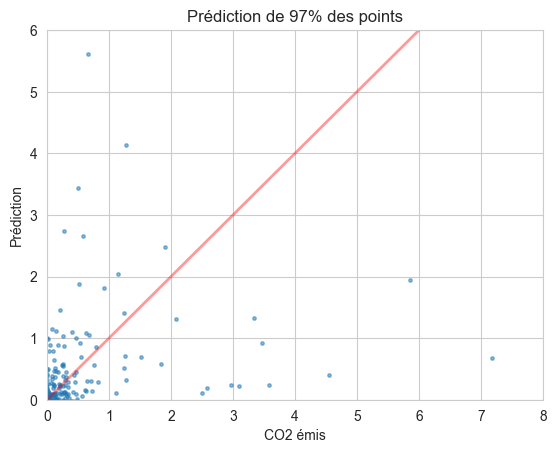

In [356]:
# Représentation graphique de la prédiction
axes = plt.gca()
plt.scatter(data=pred, x="TotalGHGEmissions", y="prediction", alpha=0.5, s=6)
plt.plot([0.0, 10], [0.0, 10], 'r-', lw=2, alpha=0.4)

plt.xlim(0, 8)
plt.ylim(0, 6)

axes.set_xlabel('CO2 émis')
axes.set_ylabel('Prédiction')

plt.title('Prédiction de 97% des points')

In [357]:
# Création d'une fonction composé des coeff de la regression triés par ordre en valeur absolue
df_pca = pd.DataFrame(data=df_pca,columns=["comp_1","comp_2","comp_3"])
coef = pd.DataFrame(data=model_pca.coef_,columns=df_pca.columns)
coef = pd.DataFrame(data=coef.transpose().values,columns=["coeff"],
                        index=coef.transpose().index)
coef["coeff_sort"] = coef["coeff"].abs()
coef = coef.sort_values(by="coeff_sort",ascending=False)
coef

,coeff,coeff_sort
comp_1,0.272602,0.272602
comp_2,0.245576,0.245576
comp_3,0.170947,0.170947


Text(0.5, 1.0, 'Coefficients de regression')

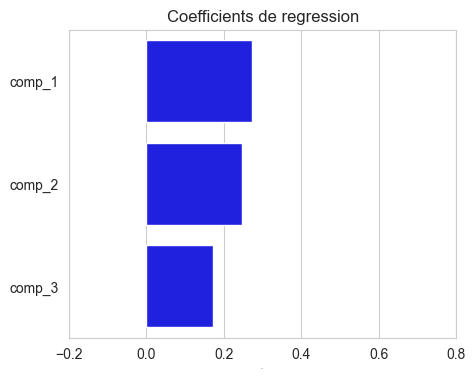

In [358]:
# Graphique des coeff

fig, ax = plt.subplots(figsize=(5, 4))
ax.set_xlim(-0.2, 0.8)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

## 2.6) Régression sur le log des données
<a class="anchor" id="Section_2.6"></a>

In [359]:
# Transformation des DF en log

df_float[df_float==0]=1
df_float["ENERGYSTARScore"]=df['ENERGYSTARScore']
df_float_log = df_au_log(df_float)
df_energy=df_float_log[["ENERGYSTARScore"]]
df_float_log=df_float_log.drop(columns=["ENERGYSTARScore"])

target[target==0]=1
target_log = df_au_log(target)

C:\Users\fbbou\AppData\Local\Temp\ipykernel_13576\1134612248.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target[target==0]=1
C:\Users\fbbou\AppData\Local\Temp\ipykernel_13576\1134612248.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target[target==0]=1
C:\Users\fbbou\AppData\Local\Temp\ipykernel_13576\1232816784.py:4: RuntimeWarning: invalid value encountered in log
  val = np.log(data_1.values)


In [360]:
df_tot= pd.concat([df_float_log,target_log],axis=1)
df_tot=df_tot.dropna(axis=0,subset="TotalGHGEmissions")
target_log=df_tot[["TotalGHGEmissions"]]
df_float_log = df_tot.drop(columns=["TotalGHGEmissions"])

In [361]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_log, target_log, test_size=0.3, random_state=0)

# Régression linéaire
tps1 = time.time()
model_log = LinearRegression().fit(X_train, y_train)
tps2 = time.time()
temps_log = tps2 - tps1
print("Temps de calcul : ",temps_log,"ms")

Temps de calcul :  0.0 ms


### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [362]:
print("R2 sur le set d'apprentissage: ",model_log.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_log.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.4430022991613727 
 R2 sur le set de test:  0.46111883429129163


In [363]:
# Création d'un DF des valeurs prédites de X_test
pred = model_log.predict(X_test)
pred=pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

1.125015766023902


In [364]:
# Création d'un DF composée de la target la prédiction et les résidus

y_log = y_test.merge(df_float_log["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_log = pd.DataFrame(y_log).reset_index()
y_log=y_log.drop(columns=["index"])
pred = pd.concat([y_log[["TotalGHGEmissions","PropertyGFATotal"]],pred],axis=1)
pred["residus"]=pred["TotalGHGEmissions"]-pred["prediction"]
pred

,TotalGHGEmissions,PropertyGFATotal,prediction,residus
0,5.455449,10.632629,3.424960,2.030489
1,3.586016,12.333731,4.708871,-1.122855
2,3.015045,11.701072,3.994193,-0.979148
3,1.733424,10.108386,2.502752,-0.769328
4,6.122975,12.843821,5.884453,0.238522
...,...,...,...,...
1000,1.423108,9.966603,2.259842,-0.836734
1001,4.927471,10.604826,2.888962,2.038510
1002,2.458734,9.961756,2.400777,0.057956
1003,4.083284,10.933107,3.848829,0.234455


<AxesSubplot: xlabel='TotalGHGEmissions', ylabel='prediction'>

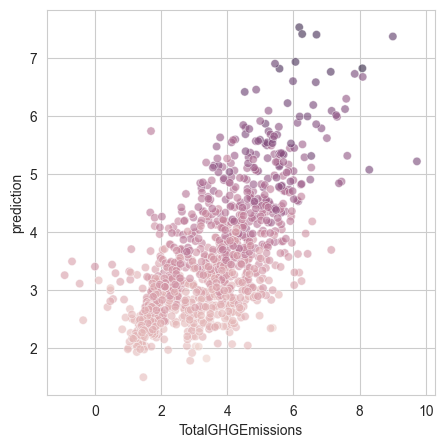

In [365]:
# Graphique de la target et de la prédiction
plt.figure(figsize = (5,5))
sns.scatterplot(data=pred, x="TotalGHGEmissions", y="prediction",hue="PropertyGFATotal",
                legend=False,alpha=0.6)

In [366]:
coef = pd.DataFrame(data=model_log.coef_,columns=df_float_log.columns)
coef = pd.DataFrame(data=coef.transpose().values,columns=["coeff"],
                        index=coef.transpose().index)
coef["coeff_sort"] = coef["coeff"].abs()
coef = coef.sort_values(by="coeff_sort",ascending=False)
coef

,coeff,coeff_sort
PropertyGFATotal,1.099896,1.099896
BulType,0.543736,0.543736
NumberofBuildings,0.258279,0.258279
PPT,-0.190918,0.190918
Zip,-0.156355,0.156355
years,0.152024,0.152024
NumberofFloors,-0.143570,0.143570
Voisin,-0.109033,0.109033
tx_gaz,-0.097492,0.097492
Council,0.058205,0.058205


Text(0.5, 1.0, 'Coefficients de regression')

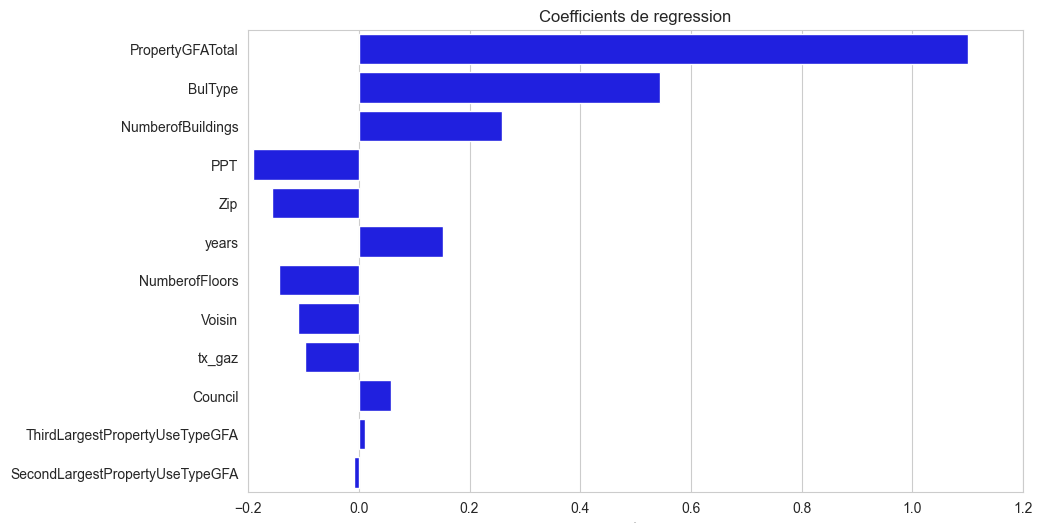

In [367]:
# Représentation graphique des coefficients

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-0.2, 1.2)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

## 2.7) Gradient Boosting Regressor sur données en log
<a class="anchor" id="Section_2.7"></a>

In [368]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_log, target_log,
                                                    test_size=0.2, random_state=0)

In [369]:
# Construction du modèle gradient boosting regressor

tps1 = time.time() # Temps d'execution

score ="r2"
param_grid = { "n_estimators":[50,100,200],
               "max_depth":[2,3,5],
               "alpha":[0.2,0.5,0.9]}

model_gbr = GridSearchCV( GradientBoostingRegressor(random_state=0),
                          param_grid,
                          cv = 10,
                          scoring = score)

model_gbr.fit(X_train,y_train)

tps2 = time.time()
temps_gbr = tps2 - tps1
print("Temps de calcul : ",temps_gbr,"ms")

C:\Users\fbbou\PycharmProjects\O-C\Projet_4\venv\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\fbbou\PycharmProjects\O-C\Projet_4\venv\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\fbbou\PycharmProjects\O-C\Projet_4\venv\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\fbbou\PycharmProjects\O-C\Projet_4\venv\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was pass

Temps de calcul :  113.82406067848206 ms


In [370]:
# Afficher les performances correspondantes

result = "mean_test_score"
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        model_gbr.cv_results_['mean_test_score'], # score moyen
        model_gbr.cv_results_['std_test_score'],  # écart-type du score
        model_gbr.cv_results_['params'] ):          # valeur de l'hyperparamètre

    print("{} = {:.3f} (+/-{:.03f}) for {}".format( result,
                                                   mean,
                                                   std*2,
                                                   params) )

Résultats de la validation croisée :
mean_test_score = 0.764 (+/-0.028) for {'alpha': 0.2, 'max_depth': 2, 'n_estimators': 50}
mean_test_score = 0.798 (+/-0.032) for {'alpha': 0.2, 'max_depth': 2, 'n_estimators': 100}
mean_test_score = 0.816 (+/-0.033) for {'alpha': 0.2, 'max_depth': 2, 'n_estimators': 200}
mean_test_score = 0.793 (+/-0.031) for {'alpha': 0.2, 'max_depth': 3, 'n_estimators': 50}
mean_test_score = 0.814 (+/-0.037) for {'alpha': 0.2, 'max_depth': 3, 'n_estimators': 100}
mean_test_score = 0.824 (+/-0.039) for {'alpha': 0.2, 'max_depth': 3, 'n_estimators': 200}
mean_test_score = 0.808 (+/-0.046) for {'alpha': 0.2, 'max_depth': 5, 'n_estimators': 50}
mean_test_score = 0.817 (+/-0.050) for {'alpha': 0.2, 'max_depth': 5, 'n_estimators': 100}
mean_test_score = 0.817 (+/-0.052) for {'alpha': 0.2, 'max_depth': 5, 'n_estimators': 200}
mean_test_score = 0.764 (+/-0.028) for {'alpha': 0.5, 'max_depth': 2, 'n_estimators': 50}
mean_test_score = 0.798 (+/-0.032) for {'alpha': 0.5, 'ma

In [371]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model_gbr.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.2, 'max_depth': 3, 'n_estimators': 200}


In [372]:
gbr = GradientBoostingRegressor( n_estimators=200,
                                max_depth=3,
                                alpha=0.2)
gbr.fit(X_train,y_train)

C:\Users\fbbou\PycharmProjects\O-C\Projet_4\venv\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.2, n_estimators=200)

### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [373]:
print("R2 sur le set d'apprentissage: ",model_gbr.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_gbr.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.8983887390873114 
 R2 sur le set de test:  0.8405735293553784


In [374]:
# Création d'un DF des valeurs prédites de X_test
pred = gbr.predict(X_test)
pred=pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

0.6224542511778273


In [375]:
# Création d'un DF composée de la target la prédiction et les résidus

y_bgr = y_test.merge(df_float_log["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_bgr = pd.DataFrame(y_bgr).reset_index()
y_bgr = y_bgr.drop(columns=["index"])
pred = pd.concat([y_bgr[["TotalGHGEmissions","PropertyGFATotal"]],pred],axis=1)
pred["residus"]=pred["TotalGHGEmissions"]-pred["prediction"]
pred

,TotalGHGEmissions,PropertyGFATotal,prediction,residus
0,5.455449,10.632629,4.015535,1.439914
1,3.586016,12.333731,4.137566,-0.551551
2,3.015045,11.701072,2.858048,0.156996
3,1.733424,10.108386,1.424935,0.308489
4,6.122975,12.843821,5.603281,0.519694
...,...,...,...,...
665,4.601062,11.986548,4.950435,-0.349373
666,3.193763,11.041016,3.027184,0.166579
667,1.488400,10.442026,1.801199,-0.312799
668,3.408504,10.281444,4.315562,-0.907058


<AxesSubplot: xlabel='TotalGHGEmissions', ylabel='prediction'>

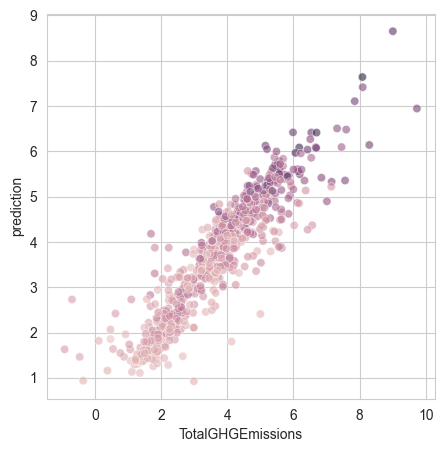

In [376]:
# Graphique de la target et de la prédiction
plt.figure(figsize = (5,5))
sns.scatterplot(data=pred, x="TotalGHGEmissions", y="prediction",hue="PropertyGFATotal",
                legend=False,alpha=0.6)

In [377]:
coef =pd.DataFrame(data=gbr.feature_importances_,index=df_float_log.columns,columns=["coeff"])

coef["coeff_sort"] = coef["coeff"].abs()
coef = coef.sort_values(by="coeff_sort",ascending=False)
coef

,coeff,coeff_sort
tx_gaz,0.511529,0.511529
PropertyGFATotal,0.356843,0.356843
PPT,0.044582,0.044582
BulType,0.026420,0.026420
years,0.014070,0.014070
NumberofFloors,0.012496,0.012496
Zip,0.008548,0.008548
ThirdLargestPropertyUseTypeGFA,0.007837,0.007837
NumberofBuildings,0.006400,0.006400
SecondLargestPropertyUseTypeGFA,0.006389,0.006389


Text(0.5, 1.0, 'Coefficients de regression')

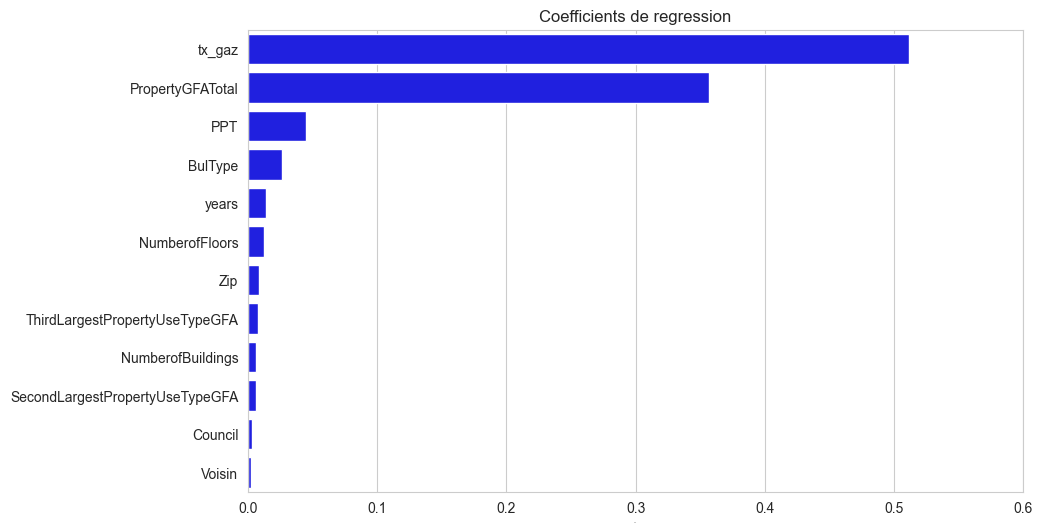

In [378]:
# Représentation graphique des coefficients

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(0, 0.6)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

## 2.8) XGBoost sur données en log
<a class="anchor" id="Section_2.8"></a>

In [379]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_log, target_log,
                                                    test_size=0.2, random_state=0)

In [380]:
# Construction du modèle gradient boosting regressor

tps1 = time.time() # Temps d'execution

score ="r2"
xgb = xgboost.XGBRegressor()
parameters = { "max_depth":[3,5,7],
               'objective':['reg:squarederror'],
               "booster" :["gbtree"],
               "n_estimators" : [100],
                "n_jobs" : [2],
               'learning_rate': [0.03, 0.05, 0.07]}

model_xgb = GridSearchCV( estimator=xgb,
                          param_grid= parameters,
                          cv = 5,
                          scoring = score
                          )

model_xgb.fit(X_train,y_train)

tps2 = time.time()
temps_xgb = tps2 - tps1
print("Temps de calcul : ",temps_xgb,"s")

Temps de calcul :  8.149952411651611 s


In [381]:
# Afficher les performances correspondantes

result = "mean_test_score"
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        model_xgb.cv_results_['mean_test_score'], # score moyen
        model_xgb.cv_results_['std_test_score'],  # écart-type du score
        model_xgb.cv_results_['params'] ):          # valeur de l'hyperparamètre

    print("{} = {:.3f} (+/-{:.03f}) for {}".format( result,
                                                   mean,
                                                   std*2,
                                                   params) )

Résultats de la validation croisée :
mean_test_score = 0.756 (+/-0.030) for {'booster': 'gbtree', 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 100, 'n_jobs': 2, 'objective': 'reg:squarederror'}
mean_test_score = 0.782 (+/-0.036) for {'booster': 'gbtree', 'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 100, 'n_jobs': 2, 'objective': 'reg:squarederror'}
mean_test_score = 0.781 (+/-0.040) for {'booster': 'gbtree', 'learning_rate': 0.03, 'max_depth': 7, 'n_estimators': 100, 'n_jobs': 2, 'objective': 'reg:squarederror'}
mean_test_score = 0.794 (+/-0.028) for {'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'n_jobs': 2, 'objective': 'reg:squarederror'}
mean_test_score = 0.808 (+/-0.035) for {'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'n_jobs': 2, 'objective': 'reg:squarederror'}
mean_test_score = 0.808 (+/-0.036) for {'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100, 'n_jobs

In [382]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model_xgb.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'booster': 'gbtree', 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 100, 'n_jobs': 2, 'objective': 'reg:squarederror'}


### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [383]:
print("R2 sur le set d'apprentissage: ",model_xgb.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_xgb.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.912434629617582 
 R2 sur le set de test:  0.8380222529368584


In [384]:
xgb = xgboost.XGBRegressor(parametre=model_xgb.best_params_)
xgb.fit(X_train,y_train)

[10:07:20] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "parametre" } are not used.



XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1,
             parametre={'booster': 'gbtree', 'learning_rate': 0.07,
                        'max_depth': 5, 'n_estimators': 100, 'n_jobs': 2,
                        'objective': 'reg:squarederror'},
             predictor='auto', ...)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

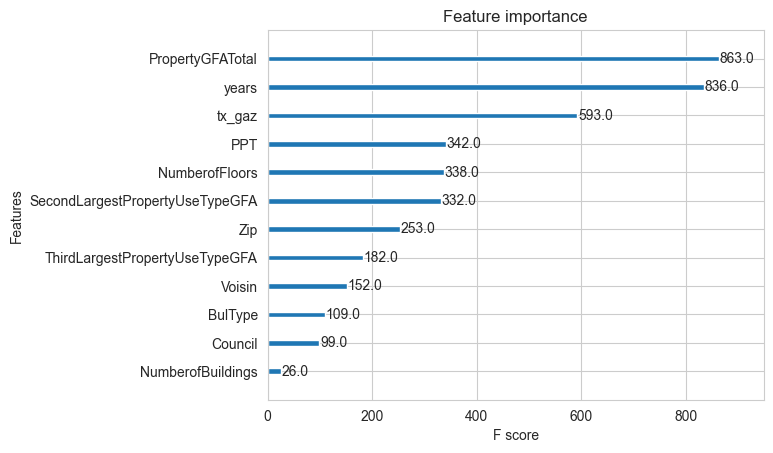

In [385]:
# Représentation graphique de l'importance de chaque variable
xgboost.plot_importance(xgb)

In [386]:
# Création d'un DF des valeurs prédites de X_test
pred = xgb.predict(X_test)
pred=pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

0.6707021604260025


In [387]:
# Création d'un DF composée de la target la prédiction et les résidus

y_xbg = y_test.merge(df_float_log["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_xbg = pd.DataFrame(y_xbg).reset_index()
y_xbg = y_xbg.drop(columns=["index"])
pred = pd.concat([y_xbg[["TotalGHGEmissions","PropertyGFATotal"]],pred],axis=1)
pred["residus"]=pred["TotalGHGEmissions"]-pred["prediction"]
pred

,TotalGHGEmissions,PropertyGFATotal,prediction,residus
0,5.455449,10.632629,3.841946,1.613503
1,3.586016,12.333731,4.238289,-0.652273
2,3.015045,11.701072,2.796760,0.218285
3,1.733424,10.108386,1.549806,0.183618
4,6.122975,12.843821,5.731732,0.391243
...,...,...,...,...
665,4.601062,11.986548,5.060518,-0.459457
666,3.193763,11.041016,2.881740,0.312023
667,1.488400,10.442026,1.688390,-0.199991
668,3.408504,10.281444,4.096859,-0.688355


<AxesSubplot: xlabel='TotalGHGEmissions', ylabel='prediction'>

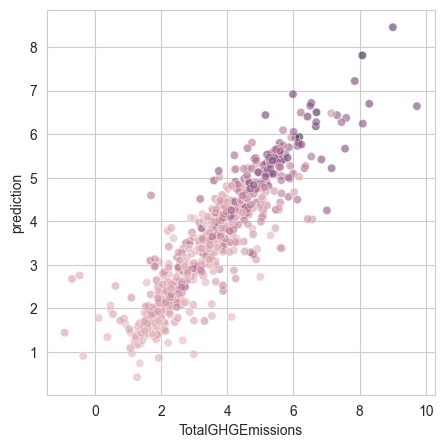

In [388]:
# Graphique de la target et de la prédiction
plt.figure(figsize = (5,5))
sns.scatterplot(data=pred, x="TotalGHGEmissions", y="prediction",hue="PropertyGFATotal",
                legend=False,alpha=0.6)

## 2.9) Régression XGBoost avec la variable ENERGYSTARScore
<a class="anchor" id="Section_2.9"></a>

In [389]:
# On inclut la variable ENERGYscore ds le modèle
df_float_log = pd.concat([df_float_log,df_energy],axis=1)

In [390]:
# Imputation des données manquantes (ENERGYscore) par les KNN

imputer = KNNImputer(n_neighbors=5)

df_float_log = pd.DataFrame(data=imputer.fit_transform(df_float_log),
                            columns=df_float_log.columns)

In [391]:
# Suppression des dernières données manquantes

df_tot = pd.concat([df_float_log,target_log],axis=1)
df_tot=df_tot.dropna(axis=0,subset="TotalGHGEmissions")
target_log = df_tot[["TotalGHGEmissions"]]
df_float_log = df_tot.drop(columns=["TotalGHGEmissions"])

In [392]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_log, target_log,
                                                    test_size=0.2, random_state=0)

In [393]:
# Construction du modèle gradient boosting regressor

tps1 = time.time() # Temps execution

score ="r2"
xgb = xgboost.XGBRegressor()
parameters = { "max_depth":[3,5,7],
               'objective':['reg:squarederror'],
               "booster" :["gbtree"],
               "n_estimators" : [100],
                "n_jobs" : [1],
               'learning_rate': [0.03, 0.05, 0.07]}

model_xgb = GridSearchCV( estimator=xgb,
                          param_grid= parameters,
                          cv = 5,
                          scoring = score
                          )

model_xgb.fit(X_train,y_train)

tps2 = time.time()
temps_xgb_E = tps2 - tps1
print("Temps de calcul : ",temps_xgb_E,"ms")

Temps de calcul :  12.64986801147461 ms


In [394]:
# Afficher les performances correspondantes

result = "mean_test_score"
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        model_xgb.cv_results_['mean_test_score'], # score moyen
        model_xgb.cv_results_['std_test_score'],  # écart-type du score
        model_xgb.cv_results_['params'] ):          # valeur de l'hyperparamètre

    print("{} = {:.3f} (+/-{:.03f}) for {}".format( result,
                                                   mean,
                                                   std*2,
                                                   params) )

Résultats de la validation croisée :
mean_test_score = 0.705 (+/-0.028) for {'booster': 'gbtree', 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 100, 'n_jobs': 1, 'objective': 'reg:squarederror'}
mean_test_score = 0.739 (+/-0.037) for {'booster': 'gbtree', 'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 100, 'n_jobs': 1, 'objective': 'reg:squarederror'}
mean_test_score = 0.736 (+/-0.048) for {'booster': 'gbtree', 'learning_rate': 0.03, 'max_depth': 7, 'n_estimators': 100, 'n_jobs': 1, 'objective': 'reg:squarederror'}
mean_test_score = 0.751 (+/-0.032) for {'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'n_jobs': 1, 'objective': 'reg:squarederror'}
mean_test_score = 0.769 (+/-0.043) for {'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'n_jobs': 1, 'objective': 'reg:squarederror'}
mean_test_score = 0.763 (+/-0.049) for {'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100, 'n_jobs

In [395]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model_xgb.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'booster': 'gbtree', 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 100, 'n_jobs': 1, 'objective': 'reg:squarederror'}


In [396]:
xgb = xgboost.XGBRegressor(parametre=model_xgb.best_params_)
xgb.fit(X_train,y_train)

[10:07:34] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "parametre" } are not used.



XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1,
             parametre={'booster': 'gbtree', 'learning_rate': 0.07,
                        'max_depth': 5, 'n_estimators': 100, 'n_jobs': 1,
                        'objective': 'reg:squarederror'},
             predictor='auto', ...)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

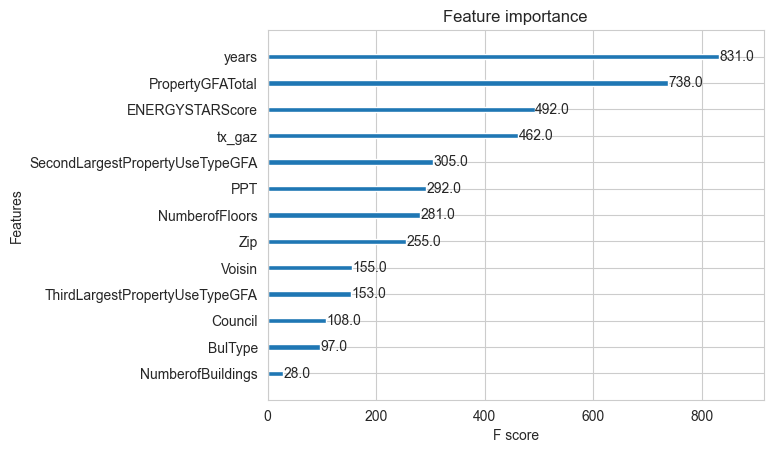

In [397]:
# Représentation graphique de l'importance de chaque variable
xgboost.plot_importance(xgb)

### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [398]:
print("R2 sur le set d'apprentissage: ",model_xgb.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_xgb.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.9004578855925838 
 R2 sur le set de test:  0.7918590840763676


In [399]:
# Création d'un DF des valeurs prédites de X_test
pred = model_xgb.predict(X_test)
pred=pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

0.7112084619588155


In [400]:
# Création d'un DF composée de la target la prédiction et les résidus

y_xgb_star = y_test.merge(df_float_log["PropertyGFATotal"],how="left",left_index=True,
                          right_index=True)
y_xgb_star = pd.DataFrame(y_xgb_star).reset_index()
y_xgb_star = y_xgb_star.drop(columns=["index"])
pred = pd.concat([y_xgb_star[["TotalGHGEmissions","PropertyGFATotal"]],pred],axis=1)
pred["residus"]=pred["TotalGHGEmissions"]-pred["prediction"]
pred

,TotalGHGEmissions,PropertyGFATotal,prediction,residus
0,5.455449,10.632629,4.522860,0.932590
1,3.586016,12.333731,3.431018,0.154998
2,3.015045,11.701072,3.009009,0.006035
3,1.733424,10.108386,1.436391,0.297033
4,6.122975,12.843821,5.319168,0.803807
...,...,...,...,...
665,4.601062,11.986548,4.557352,0.043710
666,3.193763,10.819178,3.200556,-0.006793
667,1.488400,10.442026,1.810333,-0.321934
668,3.408504,10.281444,3.800270,-0.391766


<AxesSubplot: xlabel='TotalGHGEmissions', ylabel='prediction'>

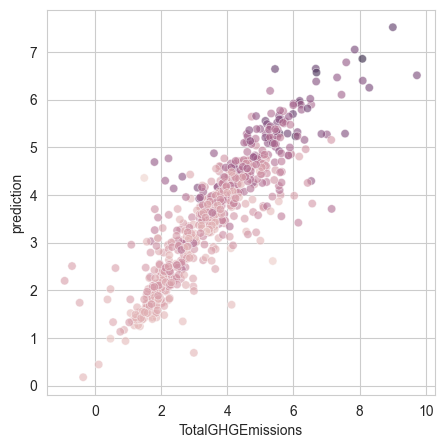

In [401]:
# Graphique de la target et de la prédiction
plt.figure(figsize = (5,5))
sns.scatterplot(data=pred, x="TotalGHGEmissions", y="prediction",hue="PropertyGFATotal",
                legend=False,alpha=0.6)

## Conclusion partie 2
<a class="anchor" id="Conclusion"></a>

# 📄 References<a class="anchor" id="Références"></a>
- [Data Seattle](https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy)
- [Librairie Pandas](https://pandas.pydata.org/docs/user_guide/index.html#)
- [Librairie scikit-learn](https://scikit-learn.org/stable/user_guide.html)
- [Librairie XGBoost](https://xgboost.readthedocs.io/en/latest/python/python_api.html)